In [31]:
#show the oil/gas type and gor relation
import pandas as pd

anp = pd.read_csv('../data/br_geodata/data_standardization/anp.csv')
wm = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
zhan = pd.read_csv('../data/br_geodata/data_standardization/zhan.csv')
pyxis = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table.csv')

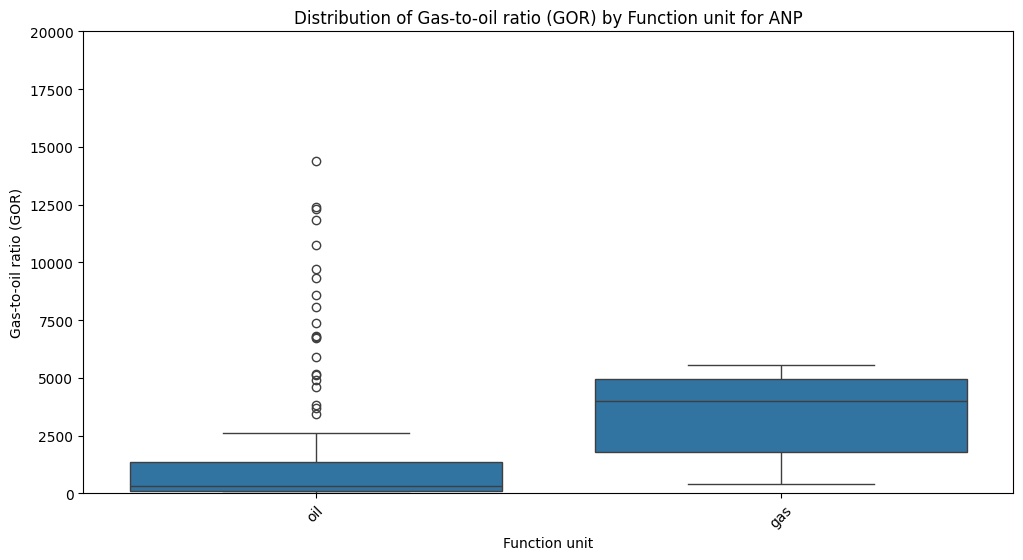

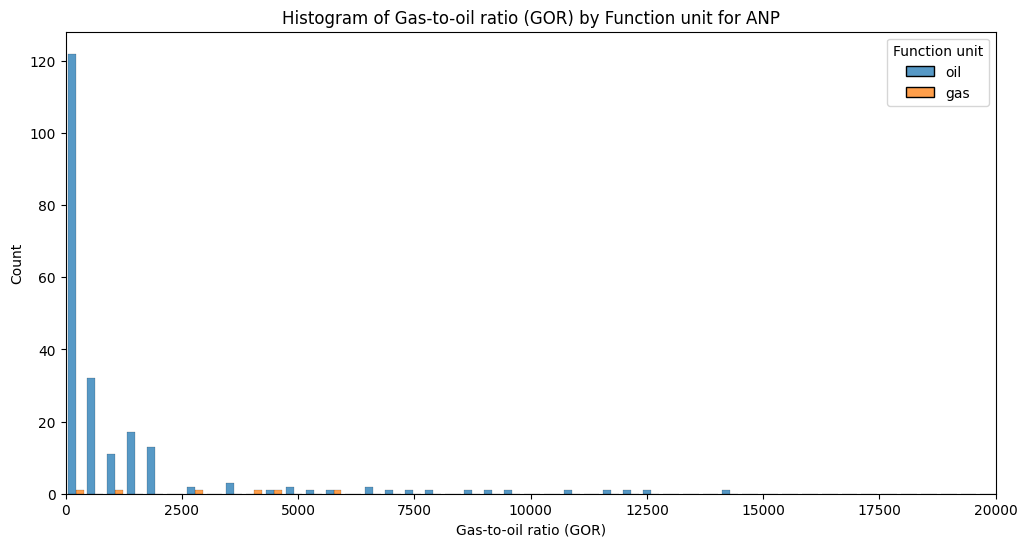

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_distribution(df, category_col, num_col, dfname, lim = 100000):
    # Check if both columns exist in the DataFrame
    if category_col not in df.columns or num_col not in df.columns:
        print(f"Error: Columns '{category_col}' and/or '{num_col}' do not exist in the DataFrame.")
        return
    
    # Plot box plot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x=category_col, y=num_col, data=df)
    ax.set_ylim(0, lim)
    plt.title(f'Distribution of {num_col} by {category_col} for {dfname}')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(data=df, x=num_col, hue=category_col, multiple="dodge", shrink=.8)
    ax.set_xlim(0, lim)
    plt.title(f'Histogram of {num_col} by {category_col} for {dfname}')
    plt.show()

plot_category_distribution(anp,'Function unit','Gas-to-oil ratio (GOR)','ANP',lim=20000)

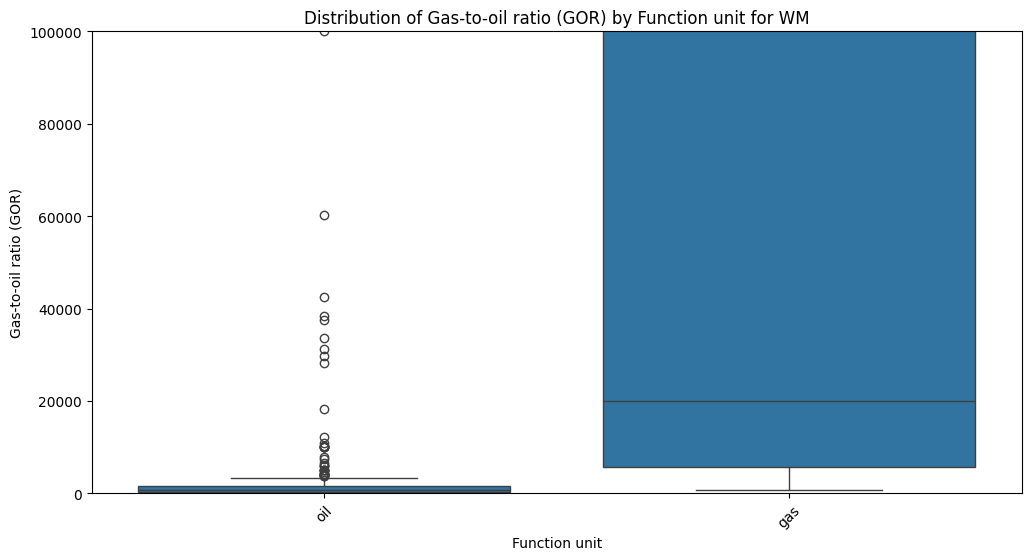

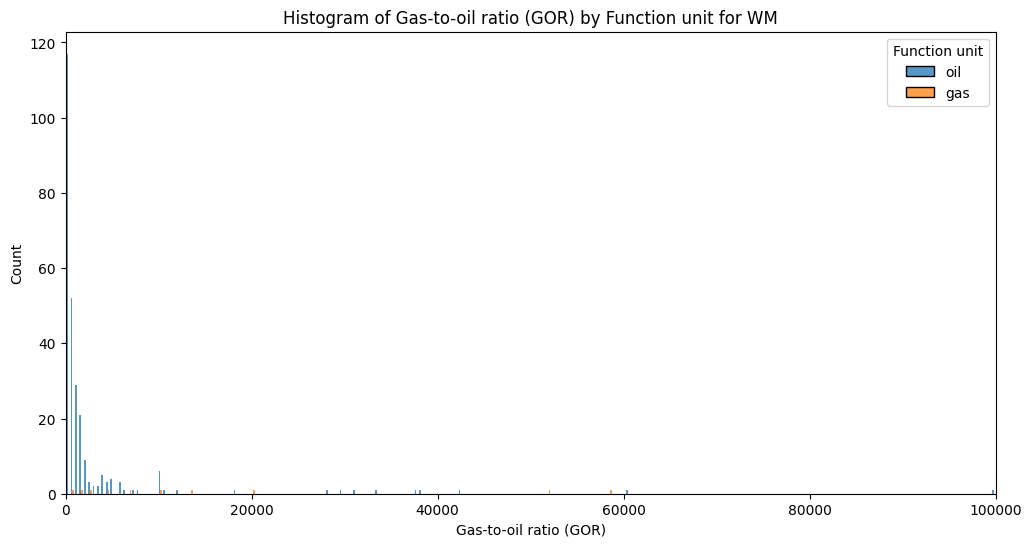

In [33]:
plot_category_distribution(wm,'Function unit','Gas-to-oil ratio (GOR)','WM')

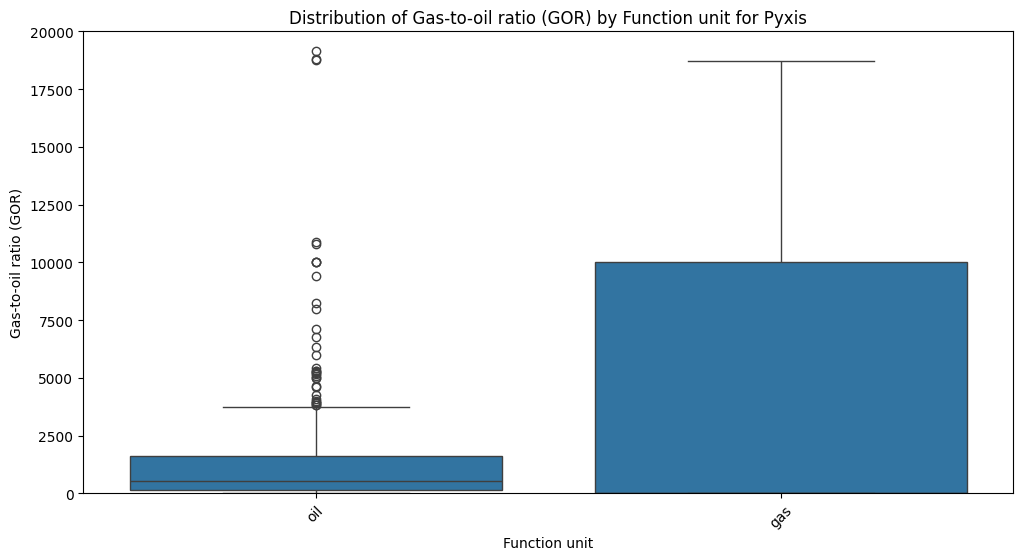

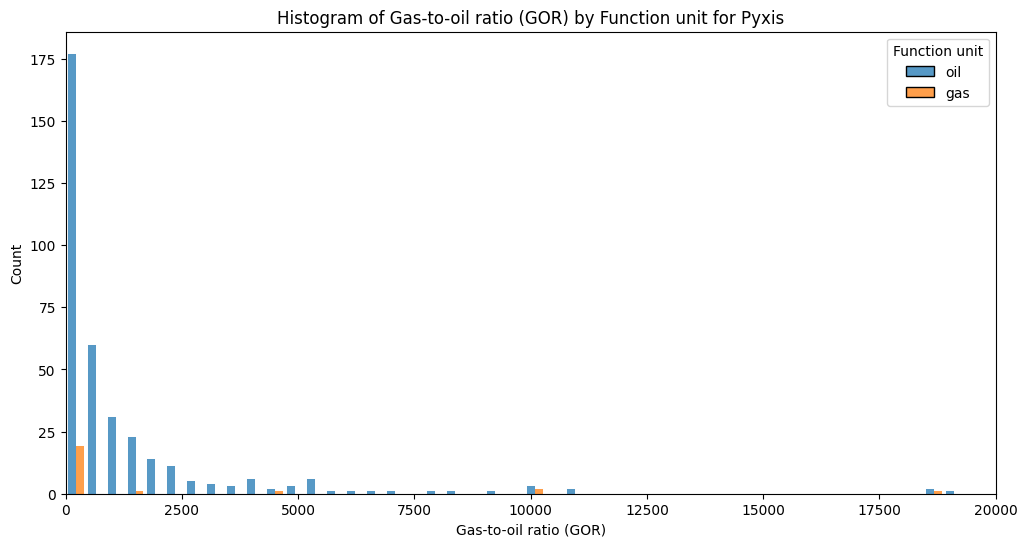

In [34]:
plot_category_distribution(pyxis,'Function unit','Gas-to-oil ratio (GOR)','Pyxis',lim=20000)

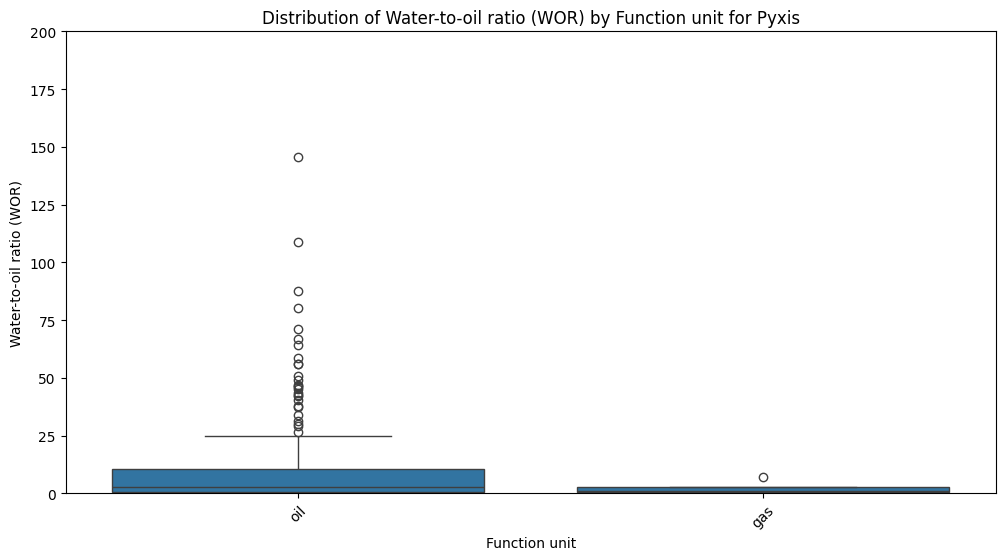

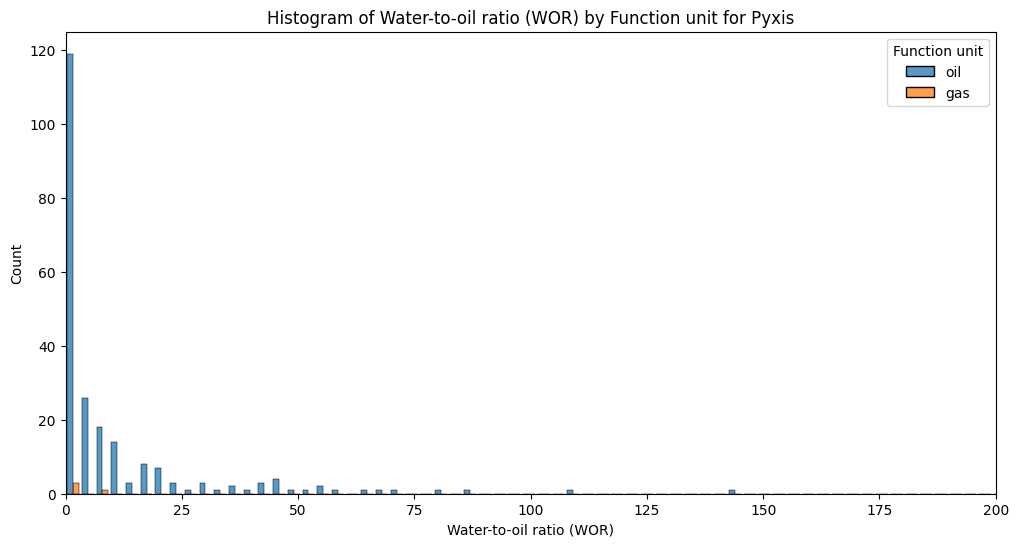

In [39]:
plot_category_distribution(pyxis,'Function unit','Water-to-oil ratio (WOR)','Pyxis',lim=200)

In [171]:
#wm field need to be cleaned further
#check for unpair field status
import geopandas as gpd

wm = gpd.read_file('../data/br_geodata/wm/BR.shp')

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def plot_convex_hulls(gdf):
    """
    Plot the original geometries and their convex hulls from a shapefile."""

    # Initialize an empty list to store convex hulls
    hull_list = []

    # Compute the convex hull for each geometry
    for index, row in gdf.iterrows():
        convex_hull = row.geometry.convex_hull
        hull_list.append(gpd.GeoSeries([convex_hull]))

    # Create a GeoDataFrame from the list of convex hulls
    hulls = gpd.GeoDataFrame(pd.concat(hull_list, ignore_index=True), columns=['geometry'])

    # Plotting the original shapes and the convex hulls
    fig, axs = plt.subplots(2, 1, figsize=(10, 15))

    # Plot original shapes
    gdf.plot(ax=axs[0], color='blue', edgecolor='k')
    axs[0].set_title("Original Shapes")  # Set title for the first subplot

    # Plot convex hulls
    hulls.plot(ax=axs[1], color='red', edgecolor='k')
    axs[1].set_title("Convex Hulls")  # Set title for the second subplot

    plt.show()

plot_convex_hulls(wm)

NameError: name 'wm' is not defined

In [173]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, Point
from sklearn.cluster import DBSCAN
import numpy as np

def clean_multipolygons(gdf, eps=10, min_samples=1):
    """
    Clean a GeoDataFrame by applying DBSCAN clustering to each MultiPolygon.
    This function breaks down MultiPolygons, clusters the individual Polygons based on
    centroid proximity, and retains only those in the largest cluster.

    Parameters:
    - gdf (GeoDataFrame): The GeoDataFrame containing the geometries.
    - eps (float): The maximum distance between centroids for clustering (default 10 km).
    - min_samples (int): The minimum number of samples in a neighborhood for considering a core point.
    """
    cleaned_geometries = []
    eps = eps/6371.0088
    
    for geometry in gdf['geometry']:
        if isinstance(geometry, Polygon):
            cleaned_geometries.append(geometry)
            continue
        
        # Extract centroids of individual polygons if it's a MultiPolygon
        if isinstance(geometry, MultiPolygon):
            polygons = list(geometry.geoms)
            centroids = np.array([poly.centroid.coords[0] for poly in polygons])
            
            # Apply DBSCAN clustering on these centroids
            db = DBSCAN(eps=eps, min_samples=min_samples,metric='haversine').fit(centroids)
            labels = db.labels_
            # Group polygons by cluster label to find the largest cluster
            clusters = {}
            for label, polygon in zip(labels, polygons):
                if label in clusters:
                    clusters[label].append(polygon)
                else:
                    clusters[label] = [polygon]
            
            # Determine the largest cluster (ignoring noise label -1)
            largest_cluster = max((v for k, v in clusters.items() if k != -1), key=len, default=None)
            
            # Construct the output geometry from the largest cluster
            if largest_cluster:
                if len(largest_cluster) == 1:
                    cleaned_geometries.append(largest_cluster[0])
                else:
                    cleaned_geometries.append(MultiPolygon(largest_cluster))
            else:
                cleaned_geometries.append(None)  # Append None if no valid cluster exists

    # Replace old geometries with cleaned ones and remove None entries
    gdf['geometry'] = cleaned_geometries
    return gdf.dropna(subset=['geometry'])

# Example usage:
cleaned_gdf = clean_multipolygons(wm, min_samples=1)


In [174]:
cleaned_gdf

,id_field_a,f_depth_mt,waterw_cnt,prodw_cnt,Unnamed_ 0,id_field_p,id_field,field_name,id_field_g,field_grou,...,f_breake_9,f_breake10,f_breake11,f_pi_ratio,f_pi_rat_1,f_pi_rat_2,f_payback_,f_paybac_1,f_paybac_2,geometry
0,8897.0,2711.334000,0,37,30379,9acf7769aeea55e2b2505c88710d4293,8897,Leste do Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.20221 -4.91142, -65.20296 -4.911..."
1,8898.0,2931.312273,0,38,6506,45988a729df28f554d96a5b9932b17e1,8898,Rio Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.30670 -4.94209, -65.30723 -4.942..."
2,8899.0,1316.921767,9,331,23624,75ac2c91d93efba8651671f18ec013d0,8899,Agua Grande,53241,Polo Rio Ventura,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.37040 -12.41547, -38.37059 -12.4..."
3,8900.0,2462.733333,0,5,2887,eedc6ed006e6f49a7010013cc1fd8a3f,8900,Apraius,54046,Polo Miranga,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.16621 -12.28790, -38.16708 -12.2..."
4,8901.0,2299.792487,25,289,21865,f4d87ed3b0dbf9c79746d00cedbb5e78,8901,Aracas,54047,Polo Bahia Terra,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.18998 -12.17233, -38.19057 -12.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,52671.0,2571.000000,0,0,678,3e91c64374748139567aa5f3d103bb93,52671,Campainha Azul,52671,Campainha Azul,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-36.91129 -5.30779, -36.91134 -5.308..."
524,53346.0,1121.000000,0,4,13191,f5bff02c9cd125d255a41bba3ff614aa,53346,Suindara,53346,Suindara,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-39.82797 -19.19771, -39.82818 -19.1..."
525,53497.0,1852.166667,0,2,12767,f16b1d1dec14dd6a94a580ca4894d11f,53497,Gaviao Belo,42941,Parque dos Gavioes,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-44.10053 -5.71356, -44.10074 -5.714..."
526,53569.0,3677.000000,0,0,1135,15b6f28363206ef318d53ecd59b53dfb,53569,Murucututu,53569,Murucututu,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-38.18539 -12.45179, -38.18544 -12.4..."


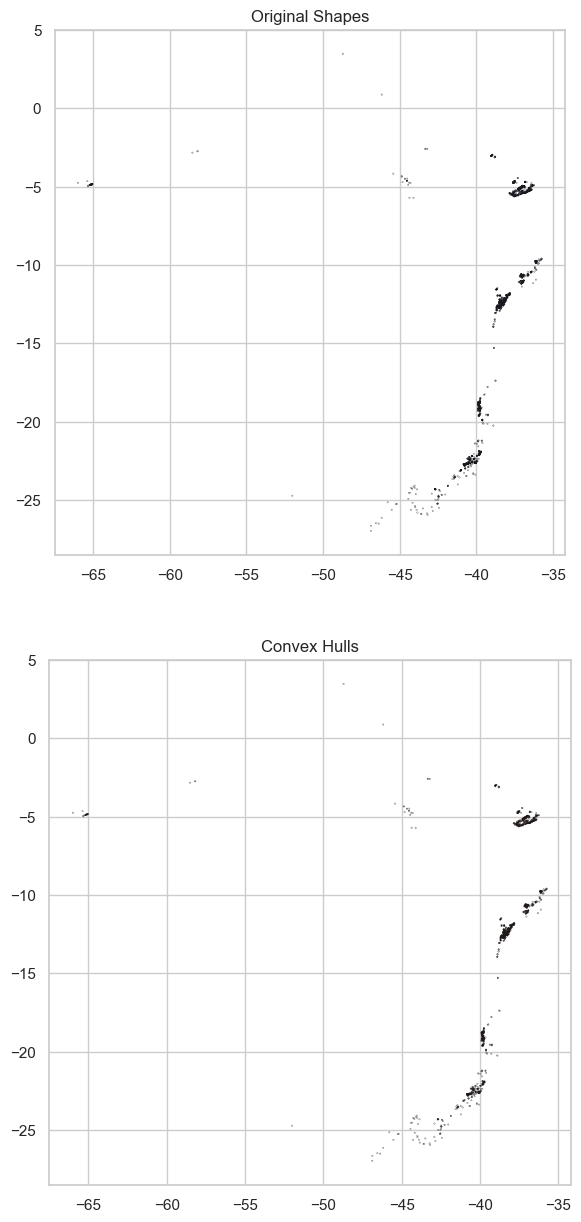

In [175]:
plot_convex_hulls(cleaned_gdf)

In [60]:
cleaned_gdf

,id_field_a,f_depth_mt,waterw_cnt,prodw_cnt,Unnamed_ 0,id_field_p,id_field,field_name,id_field_g,field_grou,...,f_breake_9,f_breake10,f_breake11,f_pi_ratio,f_pi_rat_1,f_pi_rat_2,f_payback_,f_paybac_1,f_paybac_2,geometry
0,8897.0,2711.334000,0,37,30379,9acf7769aeea55e2b2505c88710d4293,8897,Leste do Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.20221 -4.91142, -65.20296 -4.911..."
1,8898.0,2931.312273,0,38,6506,45988a729df28f554d96a5b9932b17e1,8898,Rio Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.30670 -4.94209, -65.30723 -4.942..."
2,8899.0,1316.921767,9,331,23624,75ac2c91d93efba8651671f18ec013d0,8899,Agua Grande,53241,Polo Rio Ventura,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.37040 -12.41547, -38.37059 -12.4..."
3,8900.0,2462.733333,0,5,2887,eedc6ed006e6f49a7010013cc1fd8a3f,8900,Apraius,54046,Polo Miranga,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.16621 -12.28790, -38.16708 -12.2..."
4,8901.0,2299.792487,25,289,21865,f4d87ed3b0dbf9c79746d00cedbb5e78,8901,Aracas,54047,Polo Bahia Terra,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.18998 -12.17233, -38.19057 -12.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,52671.0,2571.000000,0,0,678,3e91c64374748139567aa5f3d103bb93,52671,Campainha Azul,52671,Campainha Azul,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-36.91129 -5.30779, -36.91134 -5.308..."
524,53346.0,1121.000000,0,4,13191,f5bff02c9cd125d255a41bba3ff614aa,53346,Suindara,53346,Suindara,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-39.82797 -19.19771, -39.82818 -19.1..."
525,53497.0,1852.166667,0,2,12767,f16b1d1dec14dd6a94a580ca4894d11f,53497,Gaviao Belo,42941,Parque dos Gavioes,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-44.10053 -5.71356, -44.10074 -5.714..."
526,53569.0,3677.000000,0,0,1135,15b6f28363206ef318d53ecd59b53dfb,53569,Murucututu,53569,Murucututu,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-38.18539 -12.45179, -38.18544 -12.4..."


In [177]:
df = gpd.read_file('../data/br_geodata/merged_pyxis_field_info_table.csv', ignore_geometry=True)
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
pyxis = gpd.GeoDataFrame(df)

In [181]:
pyxis.to_file('../data/br_geodata/merged_pyxis.geojson')


In [182]:
def save_convex_hulls(gdf):
    """
    Plot the original geometries and their convex hulls from a shapefile."""

    # Initialize an empty list to store convex hulls
    hull_list = []

    # Compute the convex hull for each geometry
    for index, row in gdf.iterrows():
        convex_hull = row.geometry.convex_hull
        hull_list.append(gpd.GeoSeries([convex_hull]))

    # Create a GeoDataFrame from the list of convex hulls
    hulls = gpd.GeoDataFrame(pd.concat(hull_list, ignore_index=True), columns=['geometry'])

    gdf_hull = gdf
    gdf_hull['geometry']=hulls
    return gdf_hull

pyxis_hull = save_convex_hulls(pyxis)
pyxis_hull.to_file('../data/br_geodata/merged_pyxis_convexhull.geojson')


/Users/yaqifan/Documents/Github/Pyxis/db/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [146]:
pyxis.to_file('../data/br_geodata/merged_pyxis.geojson', driver="GeoJSON")

In [2]:
#20240531 - check pyxis match table to see what fields don't have match -> 405 valid government field with names and final pyxis field 572 fields
import pandas as pd
match = pd.read_csv('../data/br_geodata/pyxis_match_table.csv')
anp = pd.read_csv('../data/br_geodata/data_standardization/anp.csv')
wm = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
zhan = pd.read_csv('../data/br_geodata/data_standardization/zhan.csv')

In [4]:
no_match_field = match.groupby('Pyxis ID').filter(lambda x: len(x) == 1)
no_match_field

,Pyxis ID,Name,Centroid H3 Index,Source ID,Source Name,Field ID,Match Score
0,0,irara,89a8914cb83ffff,anp2024,anp,0,100.0
60,60,aguia real,89a893b60cbffff,anp2024,anp,60,100.0
64,64,muriqui,89a8914c90fffff,anp2024,anp,64,100.0
90,90,xisto sao mateus do sul,89a823ca313ffff,anp2024,anp,90,100.0
120,120,sudoeste de sapinhoa,89a98ad216fffff,anp2024,anp,120,100.0
...,...,...,...,...,...,...,...
1114,577,piracuca,89a98d2c257ffff,gogi2023,gogi,158,100.0
1118,578,pirapitanga,89a8a69680fffff,gogi2023,gogi,162,100.0
1122,579,catua,89a8b349853ffff,gogi2023,gogi,166,100.0
1160,581,sao manoel,89818bb9047ffff,gogi2023,gogi,204,100.0


In [5]:
match[match['Source Name']=='anp']

,Pyxis ID,Name,Centroid H3 Index,Source ID,Source Name,Field ID,Match Score
0,0,irara,89a8914cb83ffff,anp2024,anp,0,100.0
1,1,pescada,89818b60b87ffff,anp2024,anp,1,100.0
2,2,salgo,8981a3b6b4fffff,anp2024,anp,2,100.0
3,3,caxareu,89a8b3622dbffff,anp2024,anp,3,100.0
4,4,cexis,898116addc7ffff,anp2024,anp,4,100.0
...,...,...,...,...,...,...,...
423,423,oeste de canoas,89800e02ecfffff,anp2024,anp,423,100.0
424,424,porto do mangue,89818b0aa73ffff,anp2024,anp,424,100.0
425,425,miranga leste,89811629853ffff,anp2024,anp,425,100.0
426,426,gaviao carijo,89802eab6c7ffff,anp2024,anp,426,100.0


In [6]:
no_match_field_wm = no_match_field[no_match_field['Source Name']=='anp']
no_match_field_wm.shape

(26, 7)

In [7]:
def count_pyxis_match(data,n1,n2):
  # Filter rows with Source ID1
  n1_df = data[data['Source ID'].str.contains(n1)]

  # Filter rows with Source ID2
  n2_df = data[data['Source ID'].str.contains(n2)]

  # Find the common Pyxis IDs between wm_df and other_sources_df
  common_pyxis_ids = n1_df[n1_df['Pyxis ID'].isin(n2_df['Pyxis ID'])]['Pyxis ID'].unique()

  # Count the number of unique Pyxis IDs
  count_common_pyxis_ids = len(common_pyxis_ids)
  print(n1+' match to '+n2+' pyxis id cnt: '+str(count_common_pyxis_ids))

  return common_pyxis_ids 

a = count_pyxis_match(match,'wm','anp')
# b = count_pyxis_match(match,'zhan','wm')
# c = count_pyxis_match(match,'zhan','gogi')
# diff = (set(a) | set(b)| set(c)) - (set(a) & set(b))
# diff = (set(a) | set(b)) - (set(a) & set(b))
# diff = (set(a) | set(b)) - (set(b))
# len(diff)

wm match to anp pyxis id cnt: 352


In [8]:
def count_matches_with_sources(data,n1, sources: list,type):

    # Filter rows with Source ID 'wm'
    n1_df = data[data['Source ID'].str.contains(n1)]

    # Filter rows with the specified source IDs
    source_df = data[data['Source ID'].str.contains('|'.join(sources))]

    # Find the common Field IDs between wm_df and source_df
    common_field_ids = n1_df[n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])][type].unique()
    df = n1_df[n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])]

    # Count the number of unique Field IDs
    count_common_field_ids = len(common_field_ids)

    print("Number of unique "+type+"s from "+n1+" matched with specified sources"+str(sources)+":"+str(count_common_field_ids))

    return df

def count_unmatches_with_sources(data,n1, sources: list,type):

    # Filter rows with Source ID 'wm'
    n1_df = data[data['Source ID'].str.contains(n1)]

    # Filter rows with the specified source IDs
    source_df = data[data['Source ID'].str.contains('|'.join(sources))]

    # Find the common Field IDs between wm_df and source_df
    common_field_ids = n1_df[~n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])][type].unique()
    df = common_field_ids = n1_df[~n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])]
    # Count the number of unique Field IDs
    count_common_field_ids = len(common_field_ids)

    print("Number of unique "+type+"s from "+n1+" matched with specified sources"+str(sources)+":"+str(count_common_field_ids))

    return df

df_wm_unmatch_with_anp = count_unmatches_with_sources(match,'wm', ['anp'],'Field ID')
# df_wm_unmatch_with_anp

Number of unique Field IDs from wm matched with specified sources['anp']:143


In [9]:
wm_fieldinfo = pd.read_excel('../data/br_geodata/wm/wm_field_br.xlsx')

In [10]:
wm_unmatch_anp = wm[wm['Field ID'].isin(df_wm_unmatch_with_anp['Field ID'])]
wm_fieldinfo_unmatch_anp = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm_unmatch_anp['Original ID'])]
wm_fieldinfo_unmatch_anp['field_status']

7               Onstream
14            Contingent
18            Contingent
29            Contingent
32            Contingent
             ...        
693           Contingent
704           Contingent
707           Contingent
714           Contingent
716    Ceased Production
Name: field_status, Length: 143, dtype: object

In [11]:
wm_fieldinfo_unmatch_anp['field_status'].unique()[0]

'Onstream'

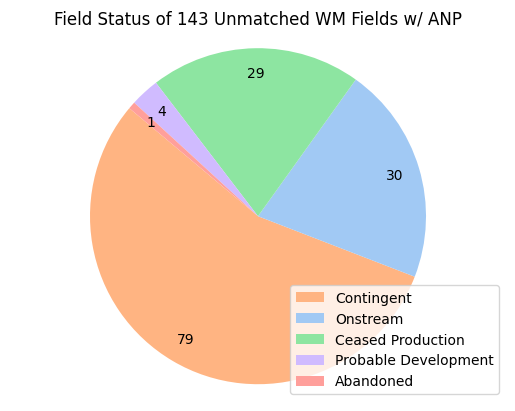

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_pie_chart(df, column_name,colors= None, title=None,loc='lower right'):
    """
    Plots a pie chart of the distribution of categories in a specified column of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column for which to plot the pie chart.

    Returns:
    None
    """
    # Count occurrences of each category
    category_counts = df[column_name].value_counts()
    if colors == None:
        c = sns.color_palette('pastel')[0:len(category_counts)]
    else:
        c =[colors[v] for v in df[column_name].value_counts().keys()]

    # Plot pie chart
    plt.figure()
    # plt.pie(category_counts, autopct='%1.1f%%',pctdistance=0.85, colors=colors, startangle=140)
    plt.pie(category_counts, autopct=lambda x: '{:.0f}'.format(x*len(df[column_name])/100),pctdistance=0.85, startangle=140,
            colors=c)
    
    if title == None:
        plt.title(f'Category Distribution for {column_name}', fontsize=14)
    else:
        plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Add legend
    plt.legend(category_counts.index,bbox_to_anchor=(1,0), loc=loc)
    
    plt.show()

wm_color_label = {}
n = len(wm_fieldinfo_unmatch_anp['field_status'].unique())
for i in range(0,n):
    wm_color_label[wm_fieldinfo_unmatch_anp['field_status'].unique()[i]] = sns.color_palette('pastel',n).as_hex()[i]
    
plot_category_pie_chart(wm_fieldinfo_unmatch_anp, 'field_status',title='Field Status of 143 Unmatched WM Fields w/ ANP',
                        colors = wm_color_label)


In [77]:
wm_unmatch = wm[wm['Field ID'].isin(no_match_field[no_match_field['Source Name']=='wm']['Field ID'])]
wm_fieldinfo_unmatch = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm_unmatch['Original ID'])]
wm_fieldinfo_unmatch['field_status']

14               Contingent
18               Contingent
29               Contingent
32               Contingent
38               Contingent
               ...         
679    Probable Development
693              Contingent
707              Contingent
714              Contingent
716       Ceased Production
Name: field_status, Length: 109, dtype: object

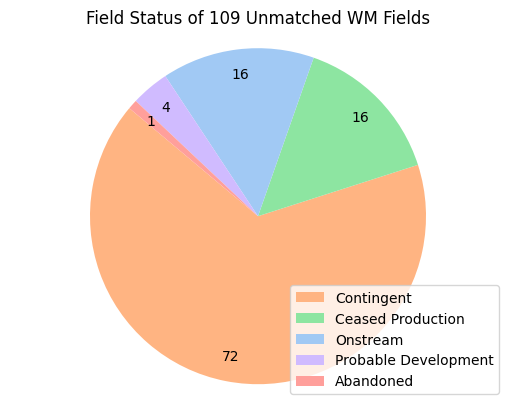

In [138]:
plot_category_pie_chart(wm_fieldinfo_unmatch, 'field_status',title='Field Status of 109 Unmatched WM Fields',
                        colors = wm_color_label)

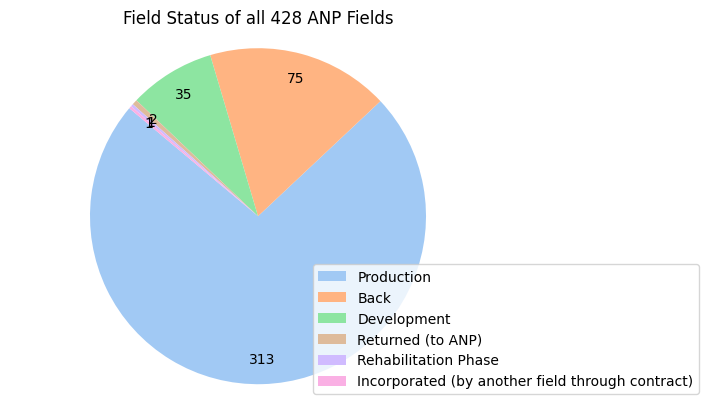

In [103]:
import geopandas as gpd
anp_fieldinfo = gpd.read_file('../data/br_geodata/anp/BR_cleaned.shp')
# print(anp_fieldinfo['Situation'].size)
anp_color_label = {}
n = len(anp_fieldinfo['Situation'].unique())
for i in range(0,n):
    anp_color_label[anp_fieldinfo['Situation'].unique()[i]] = sns.color_palette('pastel',n).as_hex()[i]
plot_category_pie_chart(anp_fieldinfo, 'Situation',title='Field Status of all 428 ANP Fields',loc =8,colors=anp_color_label)

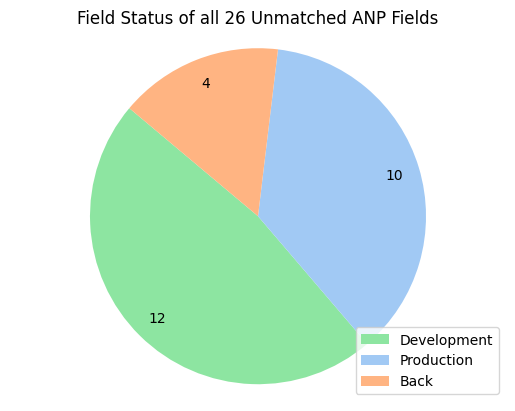

In [137]:
anp_unmatch = anp[anp['Field ID'].isin(no_match_field[no_match_field['Source Name']=='anp']['Field ID'])]
anp_fieldinfo_unmatch = anp_fieldinfo[anp_fieldinfo['Field_ID'].isin(anp_unmatch['Original ID'])]
plot_category_pie_chart(anp_fieldinfo_unmatch, 'Situation',title='Field Status of all 26 Unmatched ANP Fields',colors=anp_color_label,loc=4)

In [123]:
wm

,Unnamed: 0,Field ID,Name,Centroid H3 Index,Source ID,Function unit,Downhole pump,Water reinjection,Natural gas reinjection,Water flooding,...,Ocean tanker,Barge,Pipeline,Rail,Truck,"Ocean tanker size, if applicable",Small sources emissions,geometry,Source Name,Original ID
0,0,0,leste do urucu,898a09cd8c3ffff,wm2022,oil,1,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-65.20220670062687 -4.91142383671405...,wm,8897.0
1,1,1,rio urucu,898a09c48cfffff,wm2022,oil,1,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-65.30670133738988 -4.94208751468800...,wm,8898.0
2,2,2,agua grande,8981162e473ffff,wm2022,oil,0,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.37039521151154 -12.4154700758731...,wm,8899.0
3,3,3,apraius,898112935b3ffff,wm2022,oil,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.166209073504405 -12.287896446348...,wm,8900.0
4,4,4,aracas,8981129197bffff,wm2022,oil,0,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.18997641678381 -12.1723347143959...,wm,8901.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,523,523,campainha azul,89818b10a5bffff,wm2022,oil,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-36.911292403158804 -5.3077883328259...,wm,52671.0
524,524,524,suindara,89a893b689bffff,wm2022,oil,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-39.82796723592173 -19.1977106350774...,wm,53346.0
525,525,525,gaviao belo,89802e02237ffff,wm2022,gas,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-44.10052945592174 -5.71356188215622...,wm,53497.0
526,526,526,murucututu,8981162a47bffff,wm2022,gas,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.18539390967941 -12.4517932270100...,wm,53569.0


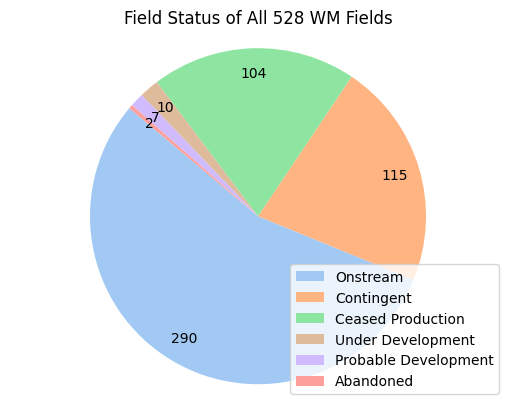

In [125]:
wm_color_label_new = wm_color_label
wm_color_label_new['Under Development'] = sns.color_palette('pastel',6).as_hex()[5]
wm_new = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm['Original ID'])]
plot_category_pie_chart(wm_new,'field_status',title='Field Status of All 528 WM Fields',colors=wm_color_label_new)

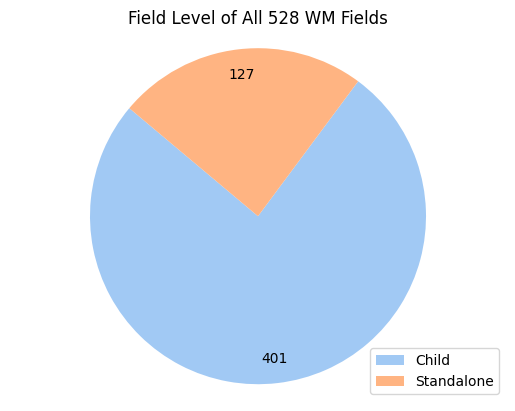

In [129]:
plot_category_pie_chart(wm_new,'field_group_level',title='Field Level of All 528 WM Fields')

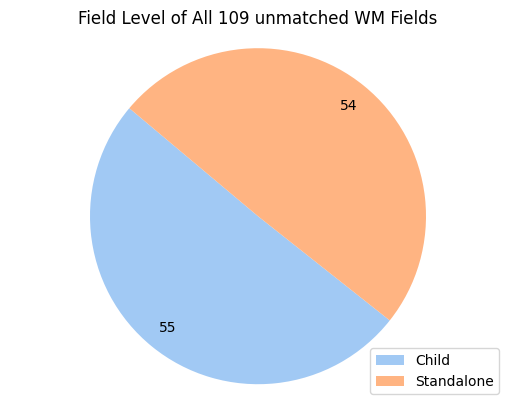

In [131]:
plot_category_pie_chart(wm_fieldinfo_unmatch, 'field_group_level',title='Field Level of All 109 unmatched WM Fields')

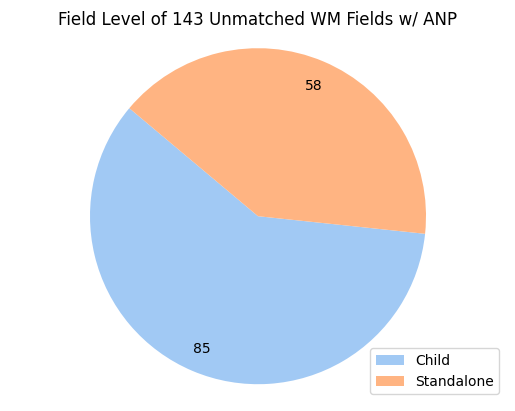

In [133]:
plot_category_pie_chart(wm_fieldinfo_unmatch_anp, 'field_group_level',title='Field Level of 143 Unmatched WM Fields w/ ANP')

In [1]:
import pandas as pd
import numpy as np

def count_non_null_cells(df):
    # Count the number of non-null values in each column and sum them
    non_null_cells = df.count().sum()
    return non_null_cells


df = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_filtered_withwm.csv')
print("Number of non-null cells:", count_non_null_cells(df))


Number of non-null cells: 11437


In [3]:
df_12 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_12paper.csv')
print("Number of non-null cells:", count_non_null_cells(df_12))

Number of non-null cells: 11437


In [4]:
import json
# List of OPGEE columns
with open('../data/OPGEE_cols.json', 'r') as json_file:
    OPGEE_cols = json.load(json_file)
OPGEE_cols['geometry'] = 'geo' #add a column

filtered_df = df_12.filter(items=OPGEE_cols.keys())
print("Number of non-null cells:", count_non_null_cells(filtered_df))

Number of non-null cells: 9317


In [6]:
df1 = pd.read_csv('../data/br_geodata/pyxis_middle_version/merged_pyxis_field_info_table_v1.csv').filter(items=OPGEE_cols.keys())
df2 = pd.read_csv('../data/br_geodata/pyxis_middle_version/merged_pyxis_field_info_table_v2.csv').filter(items=OPGEE_cols.keys())
df3 = pd.read_csv('../data/br_geodata/pyxis_middle_version/merged_pyxis_field_info_table_v3.csv').filter(items=OPGEE_cols.keys())
df4 = pd.read_csv('../data/br_geodata/pyxis_middle_version/merged_pyxis_field_info_table_v4.csv').filter(items=OPGEE_cols.keys())
df5 = pd.read_csv('../data/br_geodata/pyxis_middle_version/merged_pyxis_field_info_table_v5.csv').filter(items=OPGEE_cols.keys())

In [11]:
i =0
df = {}
for src in ['anp','wm','gogi','zhan','arma-10-162','otc-8879-ms','otc-21934-ms','otc-22612-ms','otc-30780-ms','otc-31900-ms','seg-2005-2645',
               'seg-2018-2990024','spe-94706-ms','spe-140145-ms','spe-162323-ms','spe-210009-ms']:

  df[i] = pd.read_csv('../data/br_geodata/data_standardization/'+src+'.csv').filter(items=OPGEE_cols.keys())
  i = i + 1


In [12]:
OPGEE_data_richness = {
  'ANP':count_non_null_cells(df1),
  'WM':count_non_null_cells(df2),
  'GOGI':count_non_null_cells(df3),
  'Zhan':count_non_null_cells(df4),
  '12 Papers':count_non_null_cells(df5)
}
OPGEE_data_richness

{'ANP': 7132, 'WM': 11192, 'GOGI': 11276, 'Zhan': 11324, '12 Papers': 11324}

In [13]:
cnt = 0
for i in range(0,12):
  cnt  = cnt + count_non_null_cells(df[i+4])
print(cnt)
data_richness = {
  'ANP':count_non_null_cells(df[0]),
  'WM':count_non_null_cells(df[1]),
  'GOGI':count_non_null_cells(df[2]),
  'Zhan':count_non_null_cells(df[3]),
  '12 Papers':cnt}
data_richness

236


{'ANP': 7132, 'WM': 8430, 'GOGI': 2128, 'Zhan': 1360, '12 Papers': 236}

In [15]:
df_wowm = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_with_flare_wowm.csv')
df_withwm = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_with_flare_withwm.csv')
print(count_non_null_cells(df_wowm))
print(count_non_null_cells(df_withwm))

8310
10232


/var/folders/8z/nrbsy4n11vvd1rdqlg2hf7lw0000gn/T/ipykernel_80401/3685108210.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Source', y='Data Richness', data=df, palette='coolwarm', label='Data Richness for Source')


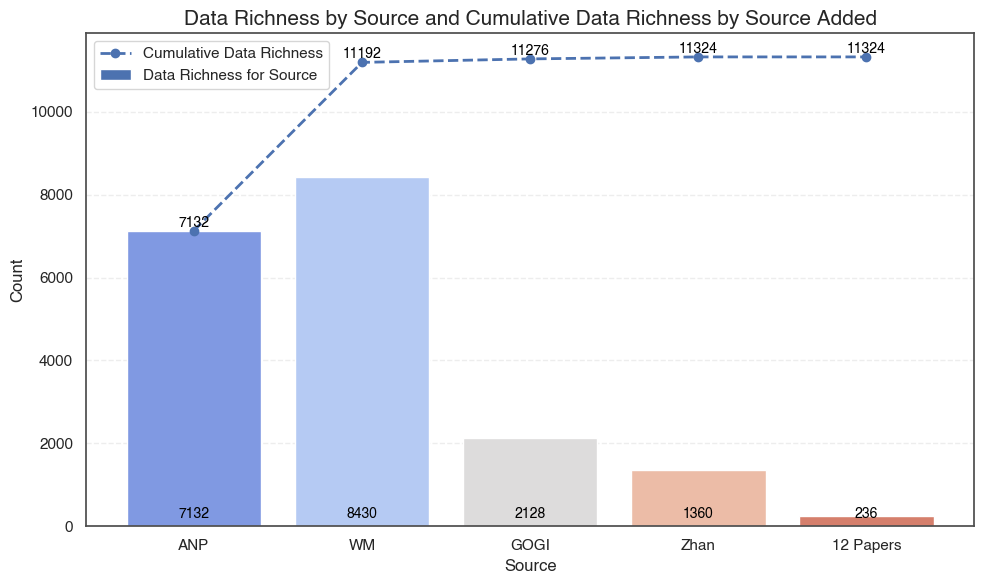

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches 

# Data dictionaries
data_richness = {'ANP': 7132, 'WM': 8430, 'GOGI': 2128, 'Zhan': 1360, '12 Papers': 236}
OPGEE_data_richness = {'ANP': 7132, 'WM': 11192, 'GOGI': 11276, 'Zhan': 11324, '12 Papers': 11324}

# Convert the dictionaries to a DataFrame
df = pd.DataFrame({
    'Source': list(data_richness.keys()),
    'Data Richness': list(data_richness.values()),
    'OPGEE Data Richness': list(OPGEE_data_richness.values())
})

# Set the Seaborn style for a cleaner look
sns.set(style="whitegrid", rc={"grid.color": ".9", "axes.edgecolor": ".3"})

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12

# Create the figure
plt.figure(figsize=(10, 6))

# Create the bar plot for data_richness and assign it to a variable for the legend
bars = sns.barplot(x='Source', y='Data Richness', data=df, palette='coolwarm', label='Data Richness for Source')

# Add data labels for the bar plot
for index, row in df.iterrows():
    plt.text(index, 200, 
             str(row['Data Richness']),
             color='black', ha="center", fontsize=10)

# Add a line plot for OPGEE_data_richness and assign it to a variable for the legend
line, = plt.plot(df['Source'], df['OPGEE Data Richness'], 
         marker='o', linewidth=2, linestyle='--', label='Total Non-Duplicate Data Richness')

# Add data labels for the line plot
for index, row in df.iterrows():
    plt.text(index, row['OPGEE Data Richness'] + 100, 
             str(row['OPGEE Data Richness']),
             color='black', ha="center", fontsize=10)

# Customize the plot
plt.title('Data Richness by Source and Cumulative Data Richness by Source Added', weight='bold', fontsize=15)
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks()
plt.yticks()

# Show a cleaner grid (on the y-axis only)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a custom legend only distinguishing the bars and the line plot
custom_legend = [plt.Line2D([0], [0], lw=2, linestyle='--', marker='o', label='Cumulative Data Richness'),
                 mpatches.Patch(label='Data Richness for Source')]

plt.legend(handles=custom_legend, loc='best')

# Tight layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../data/br_geodata/plots/Data_richness_plot.svg', format='svg', dpi=300)
# Show the plot
plt.show()


/var/folders/8z/nrbsy4n11vvd1rdqlg2hf7lw0000gn/T/ipykernel_21152/382440948.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Source', y='OPGEE Data Richness Count', data=df, palette='viridis')


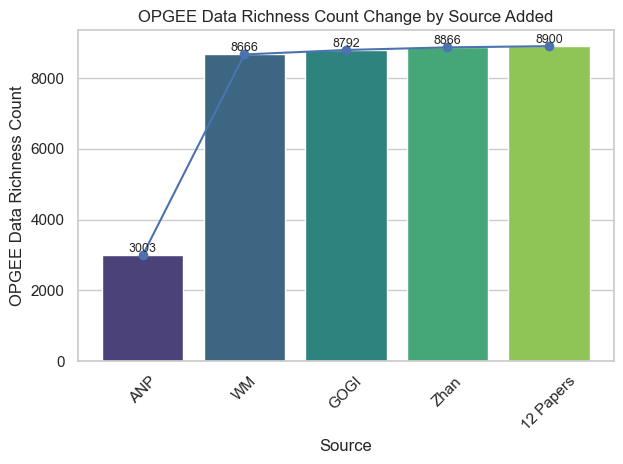

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(OPGEE_data_richness.items()), columns=['Source', 'OPGEE Data Richness Count'])

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure()
barplot = sns.barplot(x='Source', y='OPGEE Data Richness Count', data=df, palette='viridis')

# # Add data labels
for index, row in df.iterrows():
    barplot.bar_label(barplot.containers[index], fontsize=9)

# Add a line plot to connect the counts
plt.plot(df['Source'], df['OPGEE Data Richness Count'], marker='o')

# Customize the plot
plt.title('OPGEE Data Richness Count Change by Source Added')
plt.xlabel('Source')
plt.ylabel('OPGEE Data Richness Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [197]:
wm_standard = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
wm_unmatch_anp_standard = wm_standard[wm_standard['Field ID'].isin(df_wm_unmatch_with_anp['Field ID'])]
wm_unmatch_anp = wm[wm['id_field_a'].isin(wm_unmatch_anp_standard ['Original ID'])]
wm_unmatch_anp.to_file('../data/br_geodata/unmatch_geo/wm_unmatch_anp.geojson')

In [199]:
anp_unmatch = anp[anp['Field ID'].isin(no_match_field[no_match_field['Source Name']=='anp']['Field ID'])]
anp_fieldinfo_unmatch = anp_fieldinfo[anp_fieldinfo['Field_ID'].isin(anp_unmatch['Original ID'])]
anp_fieldinfo_unmatch.to_file('../data/br_geodata/unmatch_geo/anp_unmatch.geojson')

In [202]:
wm_unmatch_standard = wm_standard[wm_standard['Field ID'].isin(no_match_field[no_match_field['Source Name']=='wm']['Field ID'])]
wm_unmatch = wm[wm['id_field_a'].isin(wm_unmatch_standard ['Original ID'])]
wm_unmatch.to_file('../data/br_geodata/unmatch_geo/wm_unmatch_109.geojson')


In [3]:
import pandas as pd

def filter_pyxis_match(df):
    # Step 1: Identify Pyxis IDs that contain anp2024
    pyxis_with_anp = df[df['Source ID'] == 'anp2024']['Pyxis ID'].unique()
    
    # Step 2: Identify Pyxis IDs that contain at least three other sources
    other_sources = ['wm2022', 'gogi2023', 'zhan2021']
    source_counts = df[df['Source ID'].isin(other_sources)].groupby('Pyxis ID').size()
    pyxis_with_three_others = source_counts[source_counts >= 3].index
    
    # Combine both conditions
    pyxis_ids_to_keep = set(pyxis_with_anp).union(set(pyxis_with_three_others))
    
    # Filter the DataFrame to keep rows for the identified Pyxis IDs
    filtered_df = df[df['Pyxis ID'].isin(pyxis_ids_to_keep)]
    
    return filtered_df


pyxis_match = pd.read_csv('../data/br_geodata/pyxis_match_table.csv')
df = pd.DataFrame(pyxis_match)
filtered_df = filter_pyxis_match(df)
filtered_df.to_csv('../data/br_geodata/pyxis_match_table_filtered.csv',index=False)


In [20]:
import geopandas as gpd
import pandas as pd

merged_pyxis_data = gpd.read_file('../data/br_geodata/merged_pyxis_field_info_table_filtered.csv',ignore_geometry=True)
merged_pyxis_data['geometry'] = gpd.GeoSeries.from_wkt(merged_pyxis_data['geometry'])

In [29]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

# Initialize a map centered around Brazil with a satellite basemap
m = folium.Map(location=[-14.235004, -51.92528], zoom_start=4, tiles='CartoDB Positron', control_scale=True)

# Add a satellite tile layer
folium.TileLayer(
    tiles='https://{s}.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}{r}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors & <a href="https://carto.com/attributions">CARTO</a>',
    name='Satellite'
).add_to(m)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Define color mapping for function units
def get_color(function_unit):
    if function_unit == 'oil':
        return 'green'
    elif function_unit == 'gas':
        return 'blue'
    else:
        return 'gray'

# Add the geospatial data to the map
for idx, row in merged_pyxis_data.iterrows():
    function_unit = row['Function unit'] if pd.notna(row['Function unit']) else 'Unknown'
    geojson = folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, function_unit=function_unit: {
            'fillColor': get_color(function_unit),
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5'
        },
    )
    geojson.add_child(folium.Popup(f"Field Name: {row['Name']}<br>Function Unit: {function_unit}"))
    geojson.add_to(marker_cluster)

# Add legend
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 150px;
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp; Oil &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
     &nbsp; Gas &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
     &nbsp; Unknown &nbsp; <i class="fa fa-circle" style="color:gray"></i>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save map to an HTML file
m.save('../data/br_geodata/pyxis_geospatial_distribution_map.html')


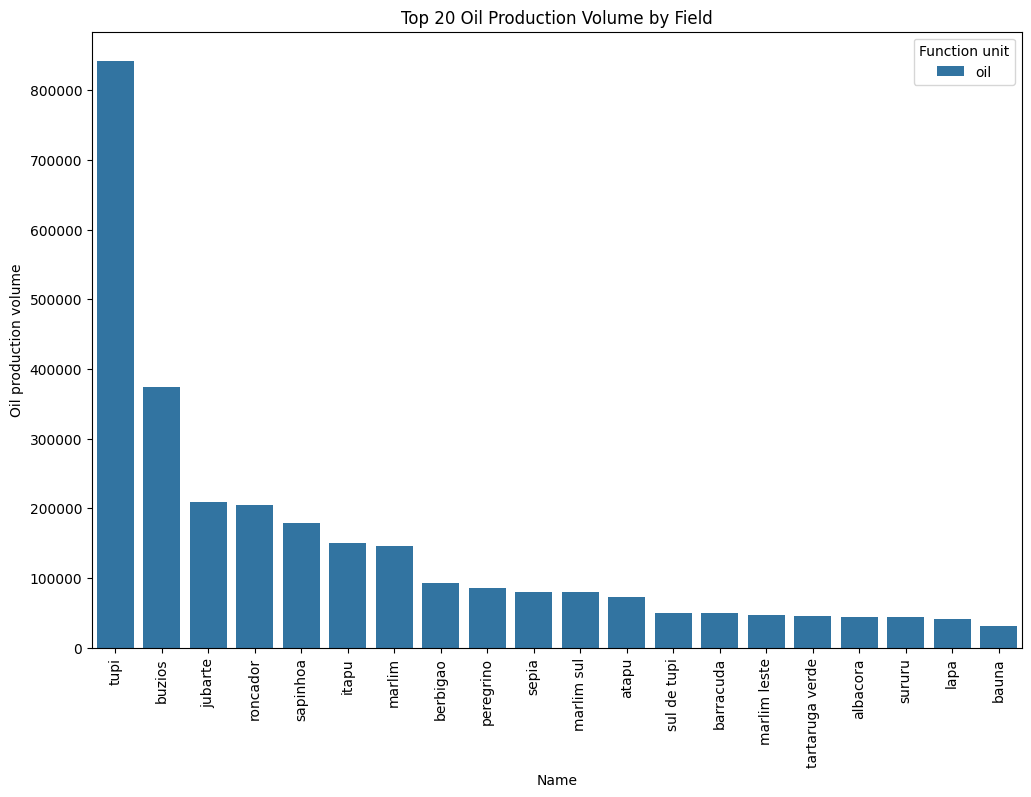

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'Oil production volume' column to numeric, handling errors
merged_pyxis_data['Oil production volume'] = pd.to_numeric(merged_pyxis_data['Oil production volume'], errors='coerce')

# Fill NaN values with 0 or drop them
merged_pyxis_data['Oil production volume'].fillna(0, inplace=True)

# Define the number of top fields to display
top_n = 20

# Filter the data to include only the top N fields by oil production volume
top_fields = merged_pyxis_data.nlargest(top_n, 'Oil production volume')

# Bar chart for oil production volume
plt.figure(figsize=(12, 8))
sns.barplot(data=top_fields, x='Name', y='Oil production volume', hue='Function unit')
plt.xticks(rotation=90)
plt.title('Top 20 Oil Production Volume by Field')
plt.show()



In [39]:
sum(merged_pyxis_data['Oil production volume'])

3421422.0638463227

In [91]:
def multiply_and_sum_not_null(df, col1, col2):
    df[col1] = pd.to_numeric(df[col1], errors='coerce')
    df[col2] = pd.to_numeric(df[col2], errors='coerce')
    filtered_df = df.dropna(subset=[col1, col2])
    product_sum = (filtered_df[col1] * filtered_df[col2]).sum()
    return product_sum

# Example usage
result = multiply_and_sum_not_null(merged_pyxis_data, 'Oil production volume', 'Gas-to-oil ratio (GOR)')
print("\nResult from the function:")
print(result)


Result from the function:
3641807736.826952


In [52]:
data_files=[]
data_files.append(1)
data_files.append(2)
data_files

[1, 2]

In [75]:
import os
import json
from abc import ABC
import pandas as pd
import h3
import geopandas as gpd
import uuid
from unidecode import unidecode
import json

# List of OPGEE columns
# with open(f'{DATA_PATH}/OPGEE_cols.json', 'r') as json_file:
#     OPGEE_cols = json.load(json_file)

with open('../data/OPGEE_cols.json', 'r') as json_file:
    OPGEE_cols = json.load(json_file)
class DataSource(ABC):
    """Abstract Base Class for data sources."""
    
    def __init__(self, data, name=None,n_explain=None, url=None, type=None, time=None, 
                 config=None, target_schema = OPGEE_cols, description='', h3_res=9):
        super().__init__()
        self.data = data
        self.name = name
        self.n_explain = n_explain
        self.url = url
        self.type = type
        self.time = time

        self.config = config
        self.target_schema = target_schema
        self.description = description
        self.h3_res = h3_res
        self.data_score_avg = None
        # self.source_id = str(uuid.uuid4())
        self.source_id = str(name)+str(time)
        self.processed_data = []
        self.metadata = {
            'Source ID': self.source_id,
            'Name': self.name,
            'Name explain': self.n_explain,
            'Source URL': self.url,
            'Source Type': self.type,
            'Source Time': self.time,
            'Reliability Score': None,
            'Recency Score': None,
            'Coverage Score': None,
            'Data Score': self.data_score_avg
        }
        
    def process(self):
        """Apply configured operations to each row of the data, mapping old column names to new."""
        field_id_counter = 0
        for _, row in self.data.iterrows():
            processed_row = {col: None for col in self.target_schema} # Initialize all columns to None
            processed_row['Field ID'] = field_id_counter
            
            field_id_counter += 1
            
            # Check if geometry data is available
            if 'geometry' in row and not pd.isnull(row.geometry):
                processed_row['Centroid H3 Index'] = h3.geo_to_h3(row.geometry.centroid.y, row.geometry.centroid.x, self.h3_res)
                processed_row['geometry'] = row.geometry
            else:
                processed_row['Centroid H3 Index'] = None
                processed_row['geometry'] = None

            processed_row['Source ID'] = self.source_id
            processed_row['Source Name'] = self.name

            for new_col_name, (input_cols, func) in self.config.items():
                if new_col_name == 'Production method':
                    production_methods = func(row, input_cols)
                    processed_row.update(production_methods)
                else:
                    inputs = [row[col] for col in input_cols if col in row] 
                    processed_row[new_col_name] = func(*inputs) if len(inputs) == len(input_cols) else None # Only proceed if all columns exist
            field_name = processed_row['Field name']
            processed_row['Name'] = unidecode(field_name).lower() if field_name else None
            self.processed_data.append(processed_row)
        
    
    def source_info_table(self):
        """Convert processed data back to DataFrame."""
        source_info = pd.DataFrame(self.processed_data)
        # List the first few columns you want at the front
        new_order = ['Field ID', 'Name', 'Centroid H3 Index', 'Source ID'] 
        # Add the rest of the columns that are not included in the new_order list
        new_order += [col for col in source_info.columns if col not in new_order]
        # Rearrange the DataFrame according to new_order
        source_info = source_info[new_order]
        return source_info
    
    def data_score(self, score_cols, score_weight = [0.5,0.3,0.2]): #calculation of the data quality score 
        self.metadata['Reliability Score'] = score_cols[0]
        self.metadata['Recency Score'] = score_cols[1]
        self.metadata['Coverage Score'] = score_cols[2]
        # for source reliability/ recency/ coverage score (coverage refer to data richness in both numerical and spatial data coverage)
        self.data_score_avg = sum([score_weight[i] * score_cols[i] for i in range(len(score_weight))])
        self.metadata['Data Score'] = self.data_score_avg
def load_source_data(file_path):
    """ Load data from an Excel file """
    return pd.read_csv(file_path)
def match_sources(pyxis_match_table, new_source, score_threshold = 60):
    """ Match new source fields with existing entries in the Pyxis Match Table """
    new_pyxis_id = pyxis_match_table['Pyxis ID'].max() + 1  # Start new IDs from the max existing ID + 1
    entries_to_add = []
    for _, row in new_source.iterrows():
        if pd.isna(row['Name']):  # Skip rows with None as the Name
            continue
        best_score = 0
        best_match_id = None
        for _, match_row in pyxis_match_table.iterrows():
            score = calculate_match_score(row['Name'], match_row['Name'], row['Centroid H3 Index'], match_row['Centroid H3 Index'])
            if score > best_score:
                best_score = score
                best_match_id = match_row['Pyxis ID']
        
        match_entry = {
            'Pyxis ID': best_match_id if best_score >= score_threshold else new_pyxis_id,
            'Name': row['Name'],
            'Centroid H3 Index': row['Centroid H3 Index'],
            'Source ID': row['Source ID'],
            'Source Name': row['Source Name'],
            'Field ID': row['Field ID'],
            'Match Score': best_score if best_score >= score_threshold else 100
        }
        entries_to_add.append(pd.DataFrame([match_entry]))
        if best_score < score_threshold:  # Only increment if no match was found
            new_pyxis_id += 1

    pyxis_match_table = pd.concat([pyxis_match_table] + entries_to_add, ignore_index=True)

    return pyxis_match_table
from pathlib import Path
from fuzzywuzzy import fuzz
import pandas as pd


def process_keep(data):
    # Function to process and keep the data as it is
    return data

def process_age_to_year(data):
    # Function to convert field age to year
    current_year = pd.Timestamp.now().year
    return current_year - data

def update_paper_data(df,name, n_explain, type, time, url, config,score):
  ds_new = DataSource(data=df, name=name, n_explain=n_explain, type=type,
                      time =time, url=url,config=config)
  ds_new.process()
  ds_source_table = ds_new.source_info_table()
  ds_new.data_score(score)
  print(ds_new.metadata)
  ds_source_table.to_csv('../data/br_geodata/data_standardization/'+name+'.csv')
#   ds_source_table.to_csv(f'{DATA_PATH}/br_geodata/data_standardization/'+name+'.csv')

def calculate_name_match_score(name1, name2, weight = 1):
    """ Calculate match score based on name similarity and H3 distance (must in the same resolution) """
    if name1 is not None and name2 is not None:
        name_score = fuzz.ratio(name1, name2)
    else:
        name_score = 0
    
    return name_score*weight

def match_sources(pyxis_match_table, new_source, score_threshold = 60):
    """ Match new source fields with existing entries in the Pyxis Match Table """
    new_pyxis_id = pyxis_match_table['Pyxis ID'].max() + 1  # Start new IDs from the max existing ID + 1
    entries_to_add = []
    for _, row in new_source.iterrows():
        if pd.isna(row['Name']):  # Skip rows with None as the Name
            continue
        best_score = 0
        best_match_id = None
        best_match_h3 = None
        for _, match_row in pyxis_match_table.iterrows():
            score = calculate_name_match_score(row['Name'], match_row['Name'])
            if score > best_score:
                best_score = score
                best_match_id = match_row['Pyxis ID']
                best_match_h3 = match_row['Centroid H3 Index']
        
        match_entry = {
            'Pyxis ID': best_match_id if best_score >= score_threshold else new_pyxis_id,
            'Name': row['Name'],
            'Centroid H3 Index': best_match_h3 if best_score >= score_threshold else row['Centroid H3 Index'],
            'Source ID': row['Source ID'],
            'Source Name': row['Source Name'],
            'Field ID': row['Field ID'],
            'Match Score': best_score if best_score >= score_threshold else 100
        }
        entries_to_add.append(pd.DataFrame([match_entry]))
        if best_score < score_threshold:  # Only increment if no match was found
            new_pyxis_id += 1

    pyxis_match_table = pd.concat([pyxis_match_table] + entries_to_add, ignore_index=True)

    return pyxis_match_table

if __name__ == '__main__':
  # Initialize the operation dictionary
  paper_op_table = {}

  # Add uniform columns to the dictionary with process_keep
  for col in OPGEE_cols:
      paper_op_table[col] = ([col], process_keep)

  # Add the specific column with a different processing function
  
# paper_op_table['Field age'] = (['Field age'], process_age_to_year)
  papers = {'spe-210009-ms':{'n_explain':'paper spe-210009-ms','type':'peer reviewed paper','time':'2022','score':[5,4.6,2.5],'url':'https://onepetro.org/SPEATCE/proceedings-abstract/22ATCE/2-22ATCE/D022S073R001/509056?redirectedFrom=PDF'},
            'spe-162323-ms':{'n_explain':'paper spe-162323-ms','type':'peer reviewed paper','time':'2012','score':[5,4.1,1.8],'url':'https://onepetro.org/SPEATCE/proceedings-abstract/22ATCE/2-22ATCE/D022S073R001/509056?redirectedFrom=PDF'},
            'spe-140145-ms':{'n_explain':'paper spe-140145-ms','type':'peer reviewed paper','time':'2011','score':[5,4.0,1.7],'url':'https://onepetro-org.stanford.idm.oclc.org/SPEDC/proceedings/11DC/All-11DC/SPE-140145-MS/149360?searchresult=1'},
            'spe-94706-ms':{'n_explain':'paper spe-94706-ms','type':'peer reviewed paper','time':'2005','score':[5,3.8,2.7],'url':'https://onepetro-org.stanford.idm.oclc.org/SPEEFDC/proceedings/05EFDC/All-05EFDC/SPE-94706-MS/88998?searchresult=1'},
            'seg-2018-2990024':{'n_explain':'paper seg-2018-2990024','type':'peer reviewed paper','time':'2018','score':[5,4.3,1.5],'url':'https://onepetro.org/SEGAM/proceedings-abstract/SEG18/All-SEG18/SEG-2018-2990024/104118?redirectedFrom=PDF'},
            'seg-2005-2645':{'n_explain':'paper seg-2005-2645','type':'peer reviewed paper','time':'2005','score':[5,3.8,1.6],'url':'https://onepetro.org/SEGAM/proceedings-abstract/SEG05/All-SEG05/SEG-2005-2645/92582'},
            'otc-31900-ms':{'n_explain':'paper otc-31900-ms','type':'peer reviewed paper','time':'2022','score':[5,4.6,1.6],'url':'https://onepetro.org/OTCONF/proceedings-abstract/22OTC/2-22OTC/D021S018R007/484398'},
            'otc-30780-ms':{'n_explain':'paper otc-30780-ms','type':'peer reviewed paper','time':'2020','score':[5,4.4,2.2],'url':'https://onepetro.org/OTCONF/proceedings-abstract/20OTC/4-20OTC/D041S051R003/107449'},
            'otc-22612-ms':{'n_explain':'paper otc-22612-ms','type':'peer reviewed paper','time':'2011','score':[5,4.0,1.7],'url':'https://onepetro.org/OTCBRASIL/proceedings-abstract/11OBRA/All-11OBRA/OTC-22612-MS/36956'},
            'otc-21934-ms':{'n_explain':'paper otc-21934-ms','type':'peer reviewed paper','time':'2011','score':[5,4.0,1.6],'url':'https://onepetro.org/OTCONF/proceedings-abstract/11OTC/All-11OTC/OTC-21934-MS/36820'},
            'otc-8879-ms':{'n_explain':'paper otc-8879-ms','type':'peer reviewed paper','time':'1998','score':[5,3.4,2.6],'url':'https://onepetro-org.stanford.idm.oclc.org/OTCONF/proceedings/98OTC/All-98OTC/OTC-8879-MS/45440?searchresult=1'},
            'arma-10-162':{'n_explain':'paper arma-10-162','type':'peer reviewed paper','time':'2010','score':[5,3.9,1.6],'url':'https://onepetro-org.stanford.idm.oclc.org/ARMAUSRMS/proceedings/ARMA10/All-ARMA10/ARMA-10-162/119406?searchresult=1'}}
  
  data_files=[]
  for paper in papers:
    #   data = pd.read_excel(f'{DATA_PATH}/br_geodata/spe/'+str(paper)+'_data.xlsx')
      data = pd.read_excel('../data/br_geodata/paper/'+str(paper)+'_data.xlsx').set_index('Field ID').T
      update_paper_data(data,name=paper,n_explain=papers[paper]['n_explain'],type=papers[paper]['type'],
                    time=papers[paper]['time'], url=papers[paper]['url'],
                    config=paper_op_table, score=papers[paper]['score']) #for source reliability/ recency/ coverage score 
      data_files.append('../data/br_geodata/data_standardization/'+str(paper)+'.csv')
    #   data_files.append(f'{DATA_PATH}/br_geodata/data_standardization/'+str(paper)+'.csv')
  
  # Load source data
  sources = [load_source_data(Path(data_file)) for data_file in data_files]
  
  # Read current the Pyxis Match Table
#   pyxis_match_table = pd.read_csv(f'{DATA_PATH}/br_geodata/pyxis_match_table.csv')
  pyxis_match_table = pd.read_csv('../data/br_geodata/pyxis_match_table.csv')
  
  # Iteratively match each source to the Pyxis Match Table
  for source in sources:
      pyxis_match_table = match_sources(pyxis_match_table, source)
  
  # Save the Pyxis Match Table
  pyxis_match_table.to_csv('../data/br_geodata/pyxis_match_table_12paper.csv', index=False)

{'Source ID': 'spe-210009-ms2022', 'Name': 'spe-210009-ms', 'Name explain': 'paper spe-210009-ms', 'Source URL': 'https://onepetro.org/SPEATCE/proceedings-abstract/22ATCE/2-22ATCE/D022S073R001/509056?redirectedFrom=PDF', 'Source Type': 'peer reviewed paper', 'Source Time': '2022', 'Reliability Score': 5, 'Recency Score': 4.6, 'Coverage Score': 2.5, 'Data Score': 4.38}
{'Source ID': 'spe-162323-ms2012', 'Name': 'spe-162323-ms', 'Name explain': 'paper spe-162323-ms', 'Source URL': 'https://onepetro.org/SPEATCE/proceedings-abstract/22ATCE/2-22ATCE/D022S073R001/509056?redirectedFrom=PDF', 'Source Type': 'peer reviewed paper', 'Source Time': '2012', 'Reliability Score': 5, 'Recency Score': 4.1, 'Coverage Score': 1.8, 'Data Score': 4.09}
{'Source ID': 'spe-140145-ms2011', 'Name': 'spe-140145-ms', 'Name explain': 'paper spe-140145-ms', 'Source URL': 'https://onepetro-org.stanford.idm.oclc.org/SPEDC/proceedings/11DC/All-11DC/SPE-140145-MS/149360?searchresult=1', 'Source Type': 'peer reviewed p